# Temperature Profile
This looks at the temperature profile, to see how it differs from the expected dry adiabat up to the LCL, followed by the moist adiabat.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, radius_earth
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.utils.radiation import frierson_atmospheric_heating
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate, integrate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
from scipy.interpolate import UnivariateSpline
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-12-04 10:43:25,728 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'omega', 't_ref', 'klzbs', 'ucomp', 'vcomp', 
            'flux_lhe', 'flux_t', 'lwdn_sfc', 'lwup_sfc', 'swdn_sfc', 'olr', 'swdn_toa',
            'dt_tg_diffusion', 'dt_tg_convection', 'dt_tg_condensation', 'tdt_rad', 
            'dt_qg_diffusion', 'dt_qg_convection', 'dt_qg_condensation', 'flux_rad', 'div']  
# Load dataset
tau_lw_ref = 1
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}"]
# exp_names = [f"k={str(tau_lw_ref).replace('.','_')}_div"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []

use_time_start = 360*2
use_time_end = 360*2.5    # just consider one year to save memory
# use_time_start = 0
# use_time_end = np.inf
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    # only keep after spin up and a bit larger than tropics
    ds_base += [ds_use.sel(time=slice(use_time_start, use_time_end), lat=slice(-30, 30)).load()]      
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

Removing div from var_keep


## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

## Single location as function of time

In [4]:
lat_sl = 9.8
lon_sl = 78             # keep away from prime meridian to stop periodicity errors
p_ind = -1
ds_use = ds_base[0].sel(lat=lat_sl, lon=lon_sl, method='nearest').isel(pfull=p_ind)

time_array = ds_use.time-0.5
n_day_seconds =  24 * 60**2
time_ind = 150
lat_ind_sl = int(np.where(ds_base[0].lat==ds_use.lat)[0])
lon_ind_sl = int(np.where(ds_base[0].lon==ds_use.lon)[0])
lat_actual_sl = float(ds_use.lat)
lon_actual_sl = float(ds_use.lon)
p_actual_sl = float(ds_use.pfull)

### MSE Equation
The moist static energy equation at a given location and time is:
$\frac{\partial h}{\partial t} + \partial_x(hu) + \partial_y(hv) + \partial_p(h\omega) = g\partial_p(F)$
where $F$ is the total energy flux.

We are using spherical coordinates so:
$\partial_x\chi = \frac{1}{r\cos \theta} \partial_{\lambda}\chi$
$\partial_y\chi = \frac{1}{r\cos \theta} \partial_{\theta}(\chi \cos \theta)$ 
where $\theta$ is latitude, $\lambda$ is longitude and $r$ is the radius of the Earth.

Below, I consider these terms in turn.

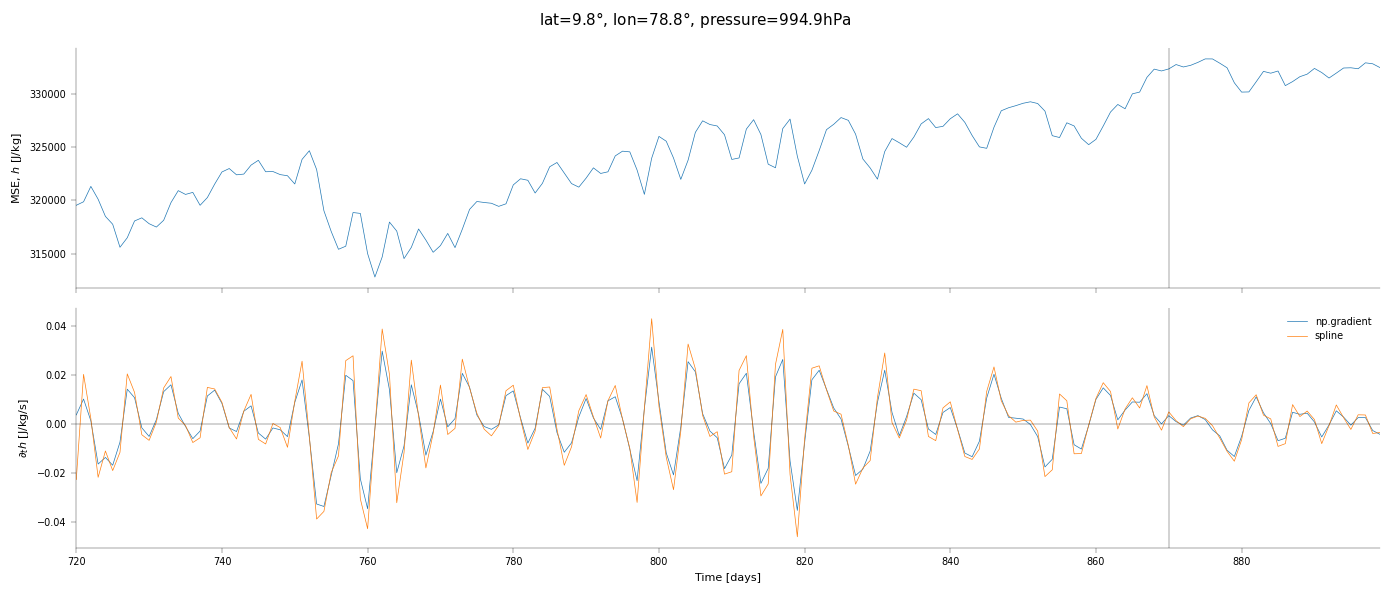

In [5]:
ds_use = ds_base[0].sel(lat=lat_sl, lon=lon_sl, method='nearest').isel(pfull=p_ind)
mse_sl = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000
mse_dt_sl = np.gradient(mse_sl, time_array)/n_day_seconds

def get_spline_deriv(x_var, y_var, s=0.00001):
    # spline works better if first normalise by mean 
    spl = UnivariateSpline(x_var, y_var/float(np.mean(y_var)), s=s)
    return spl.derivative()(x_var) * float(np.mean(y_var))

def draw_vline(ax, val):
    ylims = ax.get_ylim()
    ax.vlines(val, ylims[0], ylims[1], colors='k', lw=ax_linewidth)
    ax.set_ylim(ylims[0], ylims[1])

fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax[0].plot(time_array, mse_sl)
ax[1].plot(time_array, mse_dt_sl, label='np.gradient')
ax[1].plot(time_array, get_spline_deriv(time_array, mse_sl)/n_day_seconds, label='spline')
ax[1].hlines(0, time_array[0], time_array[-1], color='k', lw=ax_linewidth)
draw_vline(ax[0], time_array[time_ind])
draw_vline(ax[1], time_array[time_ind])
ax[0].set_xlim(time_array[0], time_array[-1])
ax[0].set_ylabel('MSE, $h$ [J/kg]')
ax[1].set_ylabel('$\partial_t h$ [J/kg/s]')
ax[1].set_xlabel('Time [days]')
ax[1].legend()
fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$, pressure={round(p_actual_sl, 1)}hPa', 
             fontsize=11)
plt.tight_layout()

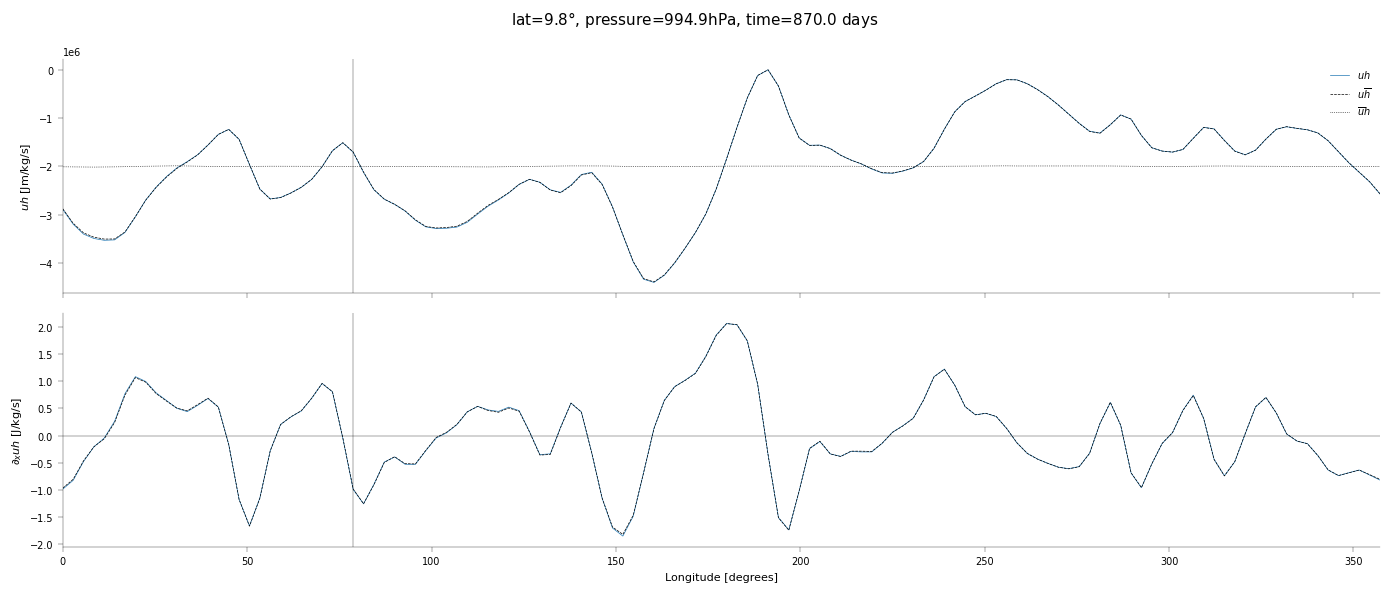

In [6]:
ds_use = ds_base[0].sel(lat=lat_actual_sl, pfull=p_actual_sl).isel(time=time_ind)
uh_sl = ds_use.ucomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000
mse_mean_use = float(moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height).mean() * 1000)

def deriv_x(var, lon, lat, axis=None):
    return np.gradient(var, np.deg2rad(lon), axis=axis) / (radius_earth * np.asarray(np.cos(np.deg2rad(lat))))

fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax[0].plot(ds_use.lon, uh_sl, label='$uh$')
ax[0].plot(ds_use.lon, ds_use.ucomp * mse_mean_use, 
           color='k', linestyle='--', label='$u\overline{h}$')
ax[0].plot(ds_use.lon, ds_use.ucomp.mean() * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000, 
           color='k', linestyle=':', label='$\overline{u}h$')
ax[0].legend()
ax[1].plot(ds_use.lon, deriv_x(uh_sl, ds_use.lon, ds_use.lat))
ax[1].plot(ds_use.lon, deriv_x(ds_use.ucomp, ds_use.lon, ds_use.lat) * mse_mean_use, color='k', linestyle='--')
# ax[1].plot(ds_use.lon, get_spline_deriv(np.deg2rad(ds_use.lon), uh_sl)/ (radius_earth * float(np.cos(np.deg2rad(ds_use.lat)))))
ax[1].hlines(0, ds_use.lon[0], ds_use.lon[-1], color='k', lw=ax_linewidth)
draw_vline(ax[0], lon_actual_sl)
draw_vline(ax[1], lon_actual_sl)
ax[0].set_xlim(ds_use.lon[0], ds_use.lon[-1])
ax[0].set_ylabel('$uh$ [Jm/kg/s]')
ax[1].set_ylabel('$\partial_x uh$ [J/kg/s]')
ax[1].set_xlabel('Longitude [degrees]')
fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, pressure={round(p_actual_sl, 1)}hPa, time={float(time_array[time_ind])} days', 
             fontsize=11)
plt.tight_layout()

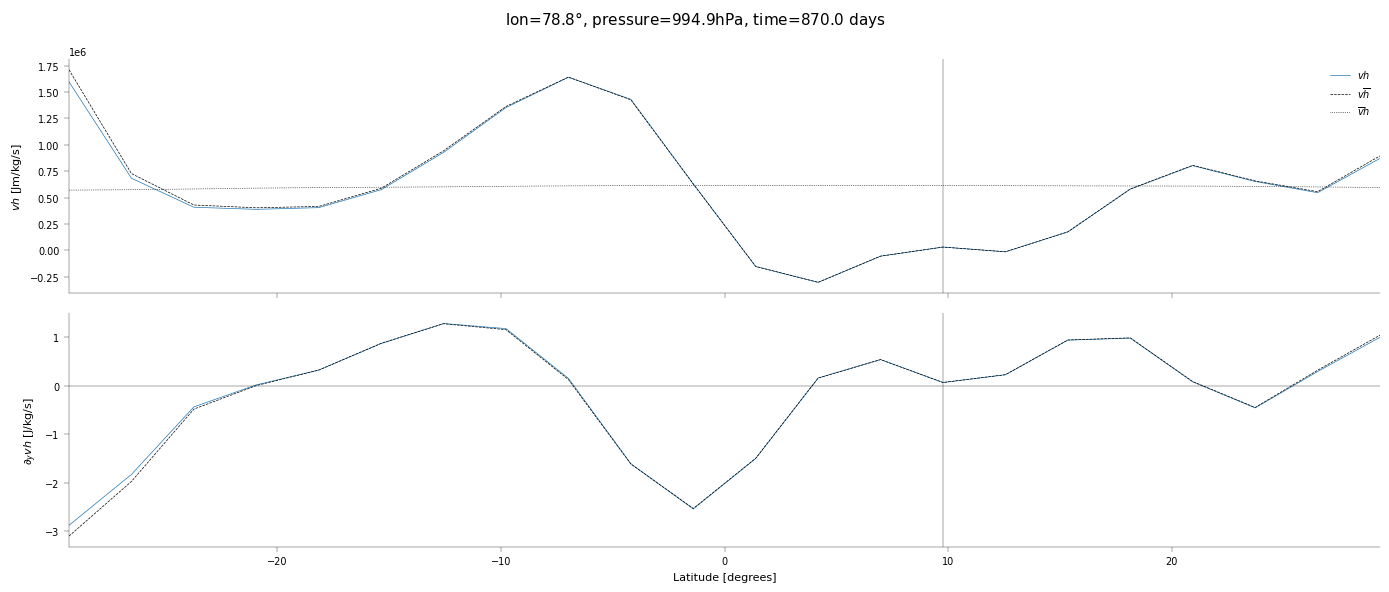

In [7]:
ds_use = ds_base[0].sel(lon=lon_actual_sl, pfull=p_actual_sl).isel(time=time_ind)
vh_sl = ds_use.vcomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000

def deriv_y(var, lat, axis=None):
    cos_lat = np.asarray(np.cos(np.deg2rad(lat)))
    return np.gradient(var * cos_lat, np.deg2rad(lat), axis=axis) / (radius_earth * cos_lat)

fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax[0].plot(ds_use.lat, vh_sl, label='$vh$')
ax[0].plot(ds_use.lat, ds_use.vcomp * mse_mean_use, 
           color='k', linestyle='--', label='$v\overline{h}$')
ax[0].plot(ds_use.lat, ds_use.vcomp.mean() * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000, 
           color='k', linestyle=':', label='$\overline{v}h$')
ax[0].legend()
ax[1].plot(ds_use.lat, deriv_y(vh_sl, ds_use.lat))
ax[1].plot(ds_use.lat, deriv_y(ds_use.vcomp, ds_use.lat) * mse_mean_use, color='k', linestyle='--')
cos_lat = np.asarray(np.cos(np.deg2rad(ds_use.lat)))
# ax[1].plot(ds_use.lat, get_spline_deriv(np.deg2rad(ds_use.lat), vh_sl * cos_lat)/ (radius_earth * cos_lat))
ax[1].hlines(0, ds_use.lat[0], ds_use.lat[-1], color='k', lw=ax_linewidth)
draw_vline(ax[0], lat_actual_sl)
draw_vline(ax[1], lat_actual_sl)
ax[0].set_xlim(ds_use.lat[0], ds_use.lat[-1])
ax[0].set_ylabel('$vh$ [Jm/kg/s]')
ax[1].set_ylabel('$\partial_y vh$ [J/kg/s]')
ax[1].set_xlabel('Latitude [degrees]')
fig.suptitle(f'lon={round(lon_actual_sl, 1)}$\degree$, pressure={round(p_actual_sl, 1)}hPa, time={float(time_array[time_ind])} days', 
             fontsize=11)
plt.tight_layout()

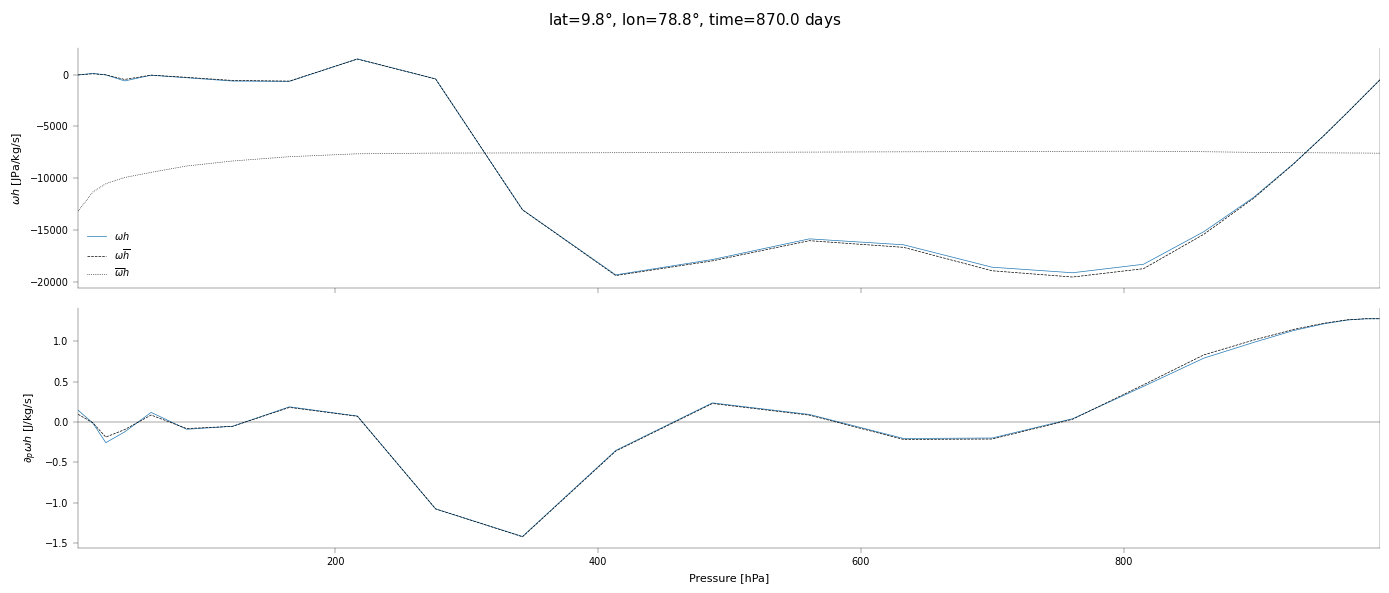

In [8]:
ds_use = ds_base[0].sel(lon=lon_actual_sl, lat=lat_actual_sl).isel(time=time_ind)
omega_h_sl = ds_use.omega * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000


fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax[0].plot(ds_use.pfull, omega_h_sl, label='$\omega h$')
ax[0].plot(ds_use.pfull, ds_use.omega * mse_mean_use, 
           color='k', linestyle='--', label='$\omega \overline{h}$')
ax[0].plot(ds_use.pfull, ds_use.omega.mean() * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000, 
           color='k', linestyle=':', label='$\overline{\omega}h$')
ax[0].legend()
ax[1].plot(ds_use.pfull, np.gradient(omega_h_sl, ds_use.pfull*100))
ax[1].plot(ds_use.pfull, np.gradient(ds_use.omega, ds_use.pfull*100) * mse_mean_use, color='k', linestyle='--')
# ax[1].plot(ds_use.pfull, get_spline_deriv(ds_use.pfull*100, omega_h_sl))
ax[1].hlines(0, ds_use.pfull[0], ds_use.pfull[-1], color='k', lw=ax_linewidth)
draw_vline(ax[0], p_actual_sl)
draw_vline(ax[1], p_actual_sl)
ax[0].set_xlim(ds_use.pfull[0], ds_use.pfull[-1])
ax[0].set_ylabel('$\omega h$ [JPa/kg/s]')
ax[1].set_ylabel('$\partial_p \omega h$ [J/kg/s]')
ax[1].set_xlabel('Pressure [hPa]')
fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$, time={float(time_array[time_ind])} days', 
             fontsize=11)
plt.tight_layout()

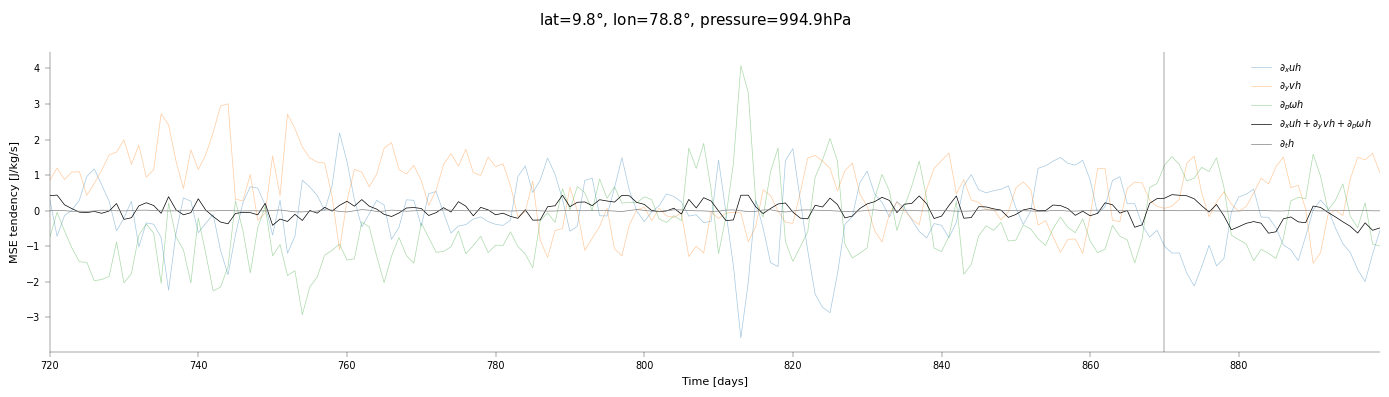

In [9]:
ds_use = ds_base[0].sel(lat=lat_actual_sl, pfull=p_actual_sl)
uh_div_sl = deriv_x(ds_use.ucomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000, 
                    ds_use.lon, ds_use.lat, axis=-1)[:, lon_ind_sl]
u_div_sl = deriv_x(ds_use.ucomp, ds_use.lon, ds_use.lat, axis=-1)[:, lon_ind_sl]
ds_use = ds_base[0].sel(lon=lon_actual_sl, pfull=p_actual_sl)
vh_div_sl = deriv_y(ds_use.vcomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000, ds_use.lat, axis=-1)[:, lat_ind_sl]
v_div_sl = deriv_y(ds_use.vcomp, ds_use.lat, axis=-1)[:, lat_ind_sl]
ds_use = ds_base[0].sel(lon=lon_actual_sl, lat=lat_actual_sl)
omega_h_div_sl = np.gradient(ds_use.omega * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * 1000, ds_use.pfull*100, 
                             axis=-1)[:, p_ind]
omega_div_sl = np.gradient(ds_use.omega, ds_use.pfull*100, axis=-1)[:, p_ind]

fig, ax = plt.subplots(1, 1, figsize=(14,4))
ax.plot(time_array, uh_div_sl, label='$\partial_x uh$', alpha=0.4)
ax.plot(time_array, vh_div_sl, label='$\partial_y vh$', alpha=0.4)
ax.plot(time_array, omega_h_div_sl, label='$\partial_p \omega h$', alpha=0.4)
ax.plot(time_array, uh_div_sl+vh_div_sl+omega_h_div_sl, color='k', label='$\partial_x uh + \partial_y vh + \partial_p \omega h$')
ax.plot(time_array, mse_dt_sl, color='grey', label='$\partial_t h$')
ax.legend()

draw_vline(ax, time_array[time_ind])
ax.set_xlim(time_array[0], time_array[-1])
ax.set_ylabel('MSE tendency [J/kg/s]')
ax.set_xlabel('Time [days]')
fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$, pressure={round(p_actual_sl, 1)}hPa', 
             fontsize=11)
plt.tight_layout()

### Divergence Sanity Check
If the dataset includes the Isca output of divergence, I check that it matches my manual computation below.

In [10]:
ds_use = ds_base[0].sel(lon=lon_actual_sl, lat=lat_actual_sl, pfull=p_actual_sl)
if 'div' in ds_use.variables:
    fig, ax = plt.subplots(1, 1, figsize=(14,4))
    ax.plot(time_array, ds_use.div, label='Isca')
    ax.plot(time_array, u_div_sl + v_div_sl, label='Manual : $\partial_x u + \partial_y v$')
    ax.plot(time_array, uh_div_sl/mse_mean_use + vh_div_sl/mse_mean_use, color=default_colors[1], linestyle=':', 
            label='Manual: $(\partial_x hu + \partial_y hv)/\overline{h}$')
    ax.hlines(0, time_array[0], time_array[-1], color='k', lw=ax_linewidth)
    ax.set_xlim(time_array[0], time_array[-1])
    ax.legend()
    ax.set_ylabel('Divergence [s$^{-1}$]')
    ax.set_xlabel('Time [days]')
    fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$, pressure={round(p_actual_sl, 1)}hPa', 
                 fontsize=11)
    plt.tight_layout()

#### Total Energy flux, $F$
In Isca, for the radiative flux, I output both `flux_rad` which is the flux at each half pressure interval in $W/m^2$, and the radiative temperature tendency `tdt_rad`, in $K/s$.

Below, I show that $c_p \times$ `tdt_rad` is equal to $g\partial_p($ `flux_rad` $)$. The slight deviation is because `flux_rad` is given on `phalf` levels while `tdt_rad` is given on `pfull` levels.

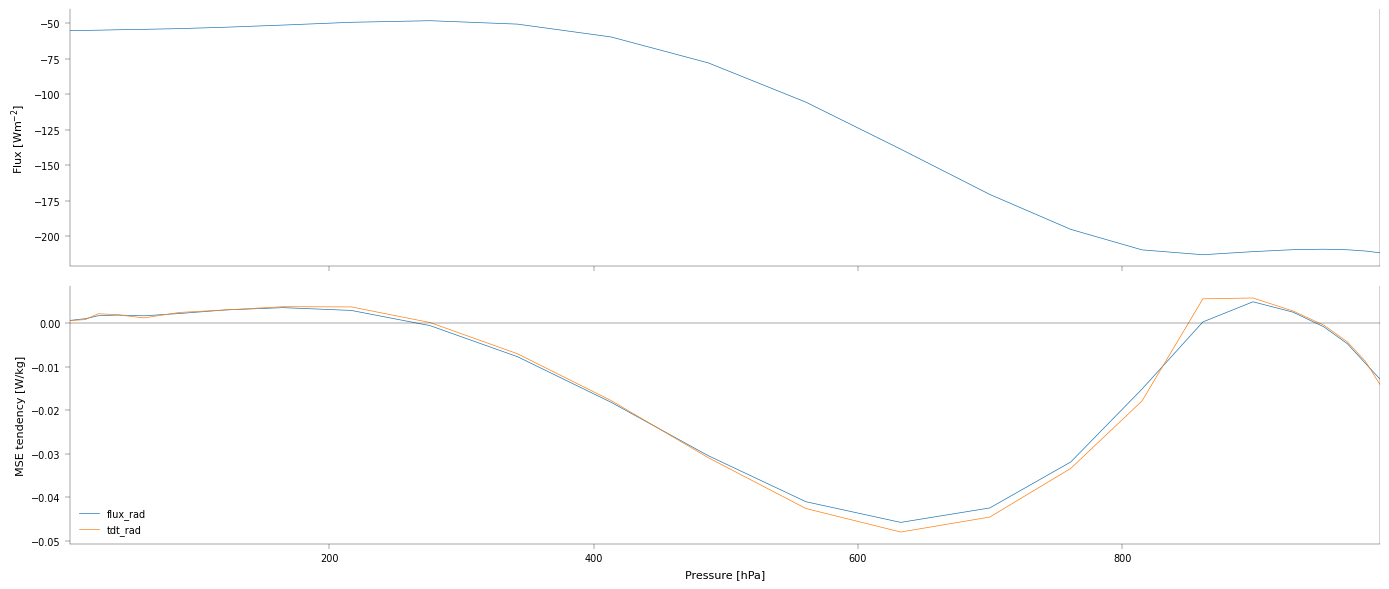

In [11]:
ds_use = ds_base[0].sel(lat=lat_actual_sl, lon=lon_actual_sl).isel(time=time_ind)

fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)
ax[0].plot(ds_use.pfull, interpolate.interp1d(ds_use.flux_rad.phalf, ds_use.flux_rad)(ds_use.pfull))
ax[1].plot(ds_use.pfull, interpolate.interp1d(ds_use.flux_rad.phalf, 
                                              g*np.gradient(ds_use.flux_rad, ds_use.flux_rad.phalf*100))(ds_use.pfull), 
           label='flux_rad')
ax[1].plot(ds_use.pfull, c_p*ds_use.tdt_rad, label='tdt_rad')
ax[1].legend()
ax[1].hlines(0, ds_use.pfull[0], ds_use.pfull[-1], color='k', lw=ax_linewidth)
draw_vline(ax[0], p_actual_sl)
draw_vline(ax[1], p_actual_sl)
ax[0].set_xlim(ds_use.pfull[0], ds_use.pfull[-1])
ax[-1].set_xlabel('Pressure [hPa]')
ax[0].set_ylabel('Flux [Wm$^{-2}$]')
ax[1].set_ylabel('MSE tendency [W/kg]')
plt.tight_layout()

### Sides of equation don't match
The other terms that go into $g\partial_pF$ are the temperature and specific humidity tendencies associated with diffusion, convection and condensation.

Clearly, below the two sides of the equation don't match up - we must be missing some contribution.

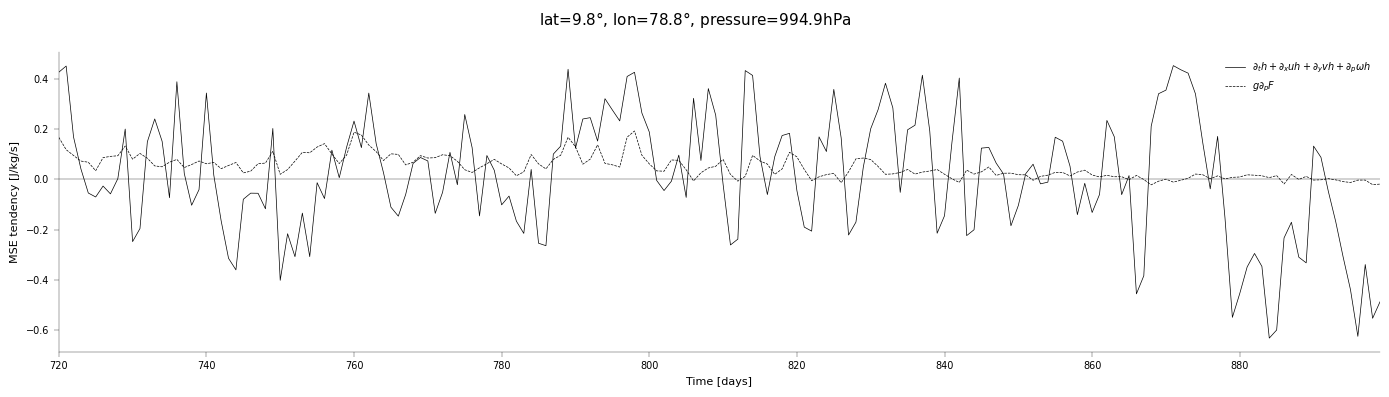

In [12]:
# Two sides of equation don't match up
ds_use = ds_base[0].sel(lat=lat_actual_sl, lon=lon_actual_sl).isel(pfull=p_ind)
# plt.plot(time_array, ds_use.dt_qg_diffusion * L_v)
# plt.plot(time_array, ds_use.dt_qg_convection * L_v)
# plt.plot(time_array, ds_use.dt_qg_condensation * L_v)
fig, ax = plt.subplots(1, 1, figsize=(14,4))
ax.plot(time_array, mse_dt_sl + uh_div_sl + vh_div_sl + omega_h_div_sl, 
         label='$\partial_t h + \partial_x uh + \partial_y vh + \partial_p \omega h$', color='k')
ax.plot(time_array, L_v * (ds_use.dt_qg_diffusion + ds_use.dt_qg_convection + ds_use.dt_qg_condensation) + 
         c_p * (ds_use.dt_tg_condensation + ds_use.dt_tg_convection + ds_use.dt_tg_diffusion + ds_use.tdt_rad), 
        label='$g\partial_p F$', color='k', linestyle='--')
ax.legend()
ax.hlines(0, time_array[0], time_array[-1], color='k', lw=ax_linewidth)
ax.set_xlim(time_array[0], time_array[-1])
ax.set_ylabel('MSE tendency [J/kg/s]')
ax.set_xlabel('Time [days]')
fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$, pressure={round(p_actual_sl, 1)}hPa', 
             fontsize=11)
plt.tight_layout()

## Vertical integrated boundary layer MSE

Now I do the exact same thing as above, but integrating all pressure levels in the boundary layer (beneath around 900hPa).

If I start with the MSE equation $\partial_t h + \partial_x(hu) + \partial_y(hv) + \partial_p(h\omega) = g\partial_p(F)$, and do the mass weighted integral $\langle \chi \rangle = \int_{900hPa}^{surf} \chi \frac{dp}{g}$, I get:

$$\langle \partial_t h\rangle + \langle \partial_x hu\rangle + \langle \partial_y hv\rangle + \frac{1}{g}(\omega h|_{surf} - 
\omega h|_{900hPa}) = F|_{surf} - F_{900hPa} + \langle \partial_t (h_{diff} + h_{conv} + h_{cond})\rangle$$

where $F_{surf} = LH + SH + LW^{\uparrow} - LW^{\downarrow} + SW^{\uparrow} - SW^{\downarrow}$ is the net upward surface flux and $F_{900hPa}$ is the net radiative upward flux (`flux_rad`) at 900hPa.

The $\langle \partial_t (h_{diff} + h_{conv} + h_{cond})\rangle$ term accounts for the parameterized diffusion, convection and condensation tendancies, i.e. the vertical integral of the `dt_tg_diffusion` and `dt_qg_diffusion` terms.

In [13]:
p_boundary_top = 900        # boundary layer is below 900hPa

# Get the 4 terms on the LHS of the equation
ds_use = ds_base[0].sel(pfull=slice(p_boundary_top, np.inf)).sel(lat=lat_actual_sl, lon=lon_actual_sl)

dh_dt_bl = integrate.simpson(np.gradient(moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000, 
                                         time_array, axis=0)/n_day_seconds/g, ds_use.pfull*100)
ds_use = ds_base[0].sel(pfull=slice(p_boundary_top, np.inf)).sel(lat=lat_actual_sl)
u_div_bl = integrate.simpson(deriv_x(ds_use.ucomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000, 
                          ds_use.lon, ds_use.lat, axis=-1)[:, :, lon_ind_sl]/g, ds_use.pfull*100)
ds_use = ds_base[0].sel(pfull=slice(p_boundary_top, np.inf)).sel(lon=lon_actual_sl)
v_div_bl = integrate.simpson(deriv_y(ds_use.vcomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000, 
                                     ds_use.lat, axis=-1)[:, :, lat_ind_sl]/g, ds_use.pfull*100)
ds_use = ds_base[0].sel(lat=lat_actual_sl, lon=lon_actual_sl).sel(pfull=slice(p_boundary_top, np.inf))
ds_use = ds_use.sel(pfull=[p_boundary_top, np.inf], method='nearest')       # only need top of boundary layer and surface values
omega_div_bl = (ds_use.omega * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000)
omega_div_bl = (omega_div_bl[:, 1] - omega_div_bl[:, 0])/g
# omega_div_bl = integrate.simpson(np.gradient(ds_use.vcomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000, 
#                                      ds_use.lat, axis=-1)[:, :, lat_ind_sl]/g, ds_use.pfull*100)

The plot below is just a sanity check that the Isca variable `flux_rad` at the largest pressure level gives the radiative upward flux at the surface. We see that it does.

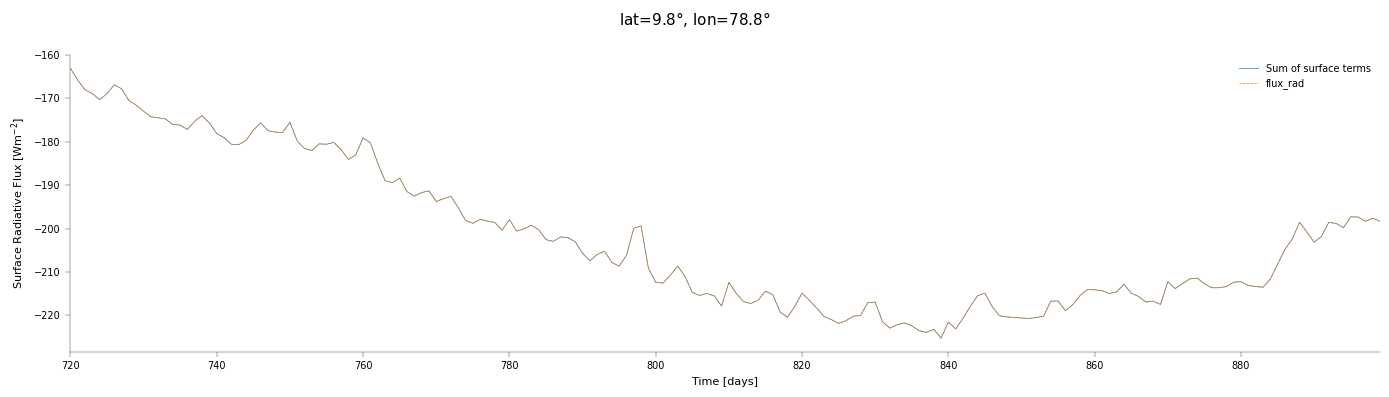

In [14]:
# RHS of equation
ds_use = ds_base[0].sel(pfull=slice(p_boundary_top, np.inf)).sel(lat=lat_actual_sl, lon=lon_actual_sl)
flux_surf = ds_use.flux_lhe + ds_use.flux_t + ds_use.lwup_sfc - ds_use.lwdn_sfc - ds_use.swdn_sfc
# flux_rad defined at half pressure levels so need to interpolate to get it at the top of boundary layer
flux_bl_top = scipy.interpolate.interp1d(ds_use.flux_rad.phalf, ds_use.flux_rad)(ds_use.pfull[0])

# Get flux terms due to diffusion, convection and condensation
flux_diff = integrate.simpson(c_p/g * ds_use.dt_tg_diffusion + L_v/g * ds_use.dt_qg_diffusion, ds_use.pfull*100)
flux_conv = integrate.simpson(c_p/g * ds_use.dt_tg_convection + L_v/g * ds_use.dt_qg_convection, ds_use.pfull*100)
flux_cond = integrate.simpson(c_p/g * ds_use.dt_tg_condensation + L_v/g * ds_use.dt_qg_condensation, ds_use.pfull*100)
# flux_param = integrate.simpson(c_p/g * (ds_use.dt_tg_diffusion + ds_use.dt_tg_convection + ds_use.dt_tg_condensation) + 
#                   L_v/g * (ds_use.dt_qg_diffusion + ds_use.dt_qg_convection + ds_use.dt_qg_condensation), 
#                   ds_use.pfull*100)

# Show net upward surface radiative flux is equal to flux_rad at lowest pressure level
fig, ax = plt.subplots(1, 1, figsize=(14,4))
ax.plot(time_array, ds_use.lwup_sfc - ds_use.lwdn_sfc - ds_use.swdn_sfc, label='Sum of surface terms')
ax.plot(time_array, ds_use.flux_rad.sel(phalf=np.inf, method='nearest'), label='flux_rad', linestyle='--')
ax.legend()
ax.set_xlim(time_array[0], time_array[-1])
ax.set_xlabel('Time [days]')
ax.set_ylabel('Surface Radiative Flux [Wm$^{-2}$]')
fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$', fontsize=11)
plt.tight_layout()

Below, we see that the LHS and RHS of the vertically integrated MSE equation don't match up.

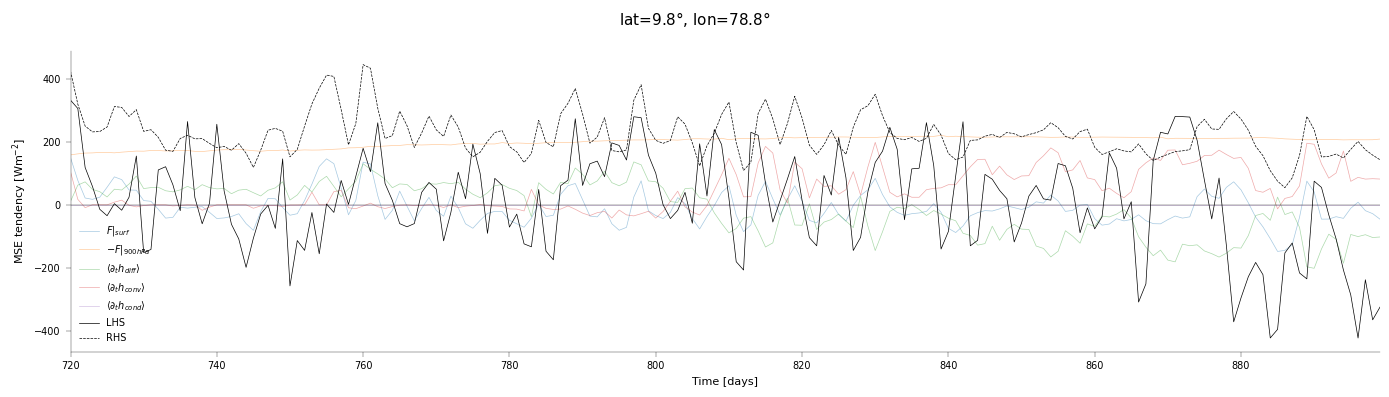

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(14,4))
# ax.plot(time_array, dh_dt_bl, alpha=0.4, label='$\langle \partial_t h\\rangle$')
# ax.plot(time_array, u_div_bl, alpha=0.4, label='$\langle \partial_x hu\\rangle$')
# ax.plot(time_array, v_div_bl, alpha=0.4, label='$\langle \partial_y hv\\rangle$')
# ax.plot(time_array, omega_div_bl, alpha=0.4, label='$\langle \partial_p h\omega\\rangle$')
ax.plot(time_array, flux_surf, alpha=0.4, label='$F|_{surf}$')
ax.plot(time_array, -flux_bl_top, alpha=0.4, label='$-F|_{900hPa}$')
ax.plot(time_array, flux_diff, alpha=0.4, label='$\langle \partial_t h_{diff}\\rangle$')
ax.plot(time_array, flux_conv, alpha=0.4, label='$\langle \partial_t h_{conv}\\rangle$')
ax.plot(time_array, flux_cond, alpha=0.4, label='$\langle \partial_t h_{cond}\\rangle$')
ax.plot(time_array, dh_dt_bl + 1*(u_div_bl + v_div_bl + omega_div_bl), color='k', label='LHS')
ax.plot(time_array, flux_surf-flux_bl_top+flux_diff+flux_conv+flux_cond, color='k', linestyle='--', label='RHS')
ax.hlines(0, time_array[0], time_array[-1], color='k', lw=ax_linewidth)
ax.set_xlim(time_array[0], time_array[-1])
ax.legend()
ax.set_xlabel('Time [days]')
ax.set_ylabel('MSE tendency [Wm$^{-2}$]')
fig.suptitle(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$', fontsize=11)
plt.tight_layout()
# ax.set_ylim(-2500,2500)

### Sanity Check of what net TOA flux is
This shows that `flux_rad` at the lowest `phalf` value is equal to the net upward flux at the TOA, as can be computed from `albedo`, `swdn_sfc`, `swdn_toa` and `olr`.

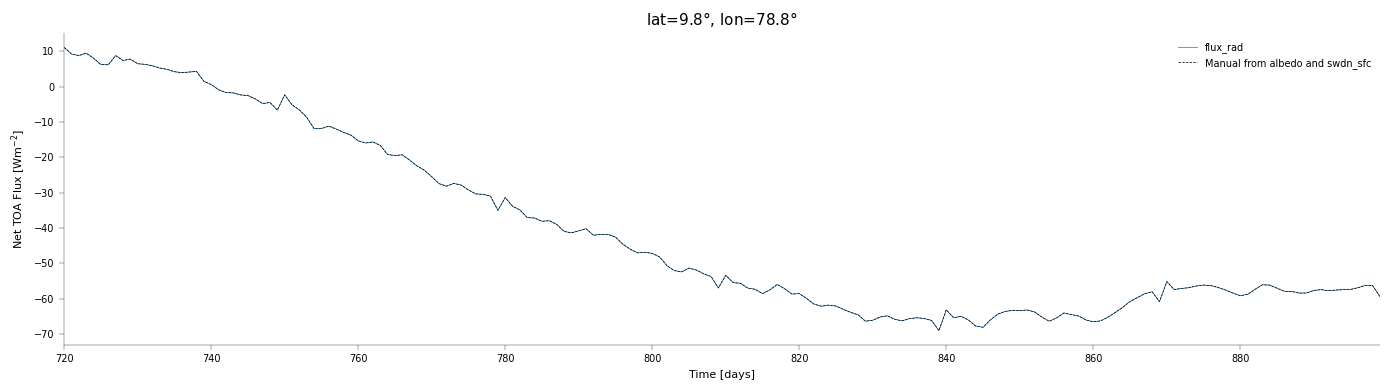

In [34]:
ds_use = ds_base[0].sel(lat=lat_actual_sl, lon=lon_actual_sl)
fig, ax = plt.subplots(1, 1, figsize=(14,4))
ax.plot(time_array, ds_use.flux_rad[:, 0], color=default_colors[0], label='flux_rad')
# albedo[0]/(1-albedo[0]) * ds_use.swdn_sfc is swup_toa due to absorption from atmosphere and reflection from surface
ax.plot(time_array, albedo[0]/(1-albedo[0]) * ds_use.swdn_sfc - ds_use.swdn_toa + ds_use.olr, color='k', linestyle='--', 
        label='Manual from albedo and swdn_sfc')
ax.legend()
ax.set_xlim(time_array[0], time_array[-1])
ax.set_xlabel('Time [days]')
ax.set_ylabel('Net TOA Flux [Wm$^{-2}$]')
ax.set_title(f'lat={round(lat_actual_sl, 1)}$\degree$, lon={round(lon_actual_sl, 1)}$\degree$', fontsize=11)
plt.tight_layout()

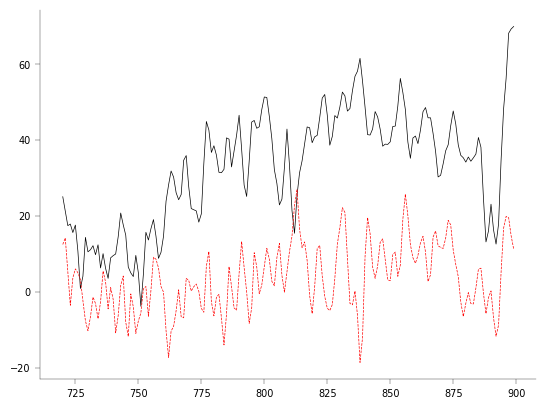

In [37]:
ds_use = ds_base[0].sel(lat=lat_actual_sl).mean(dim='lon')
flux_rad = frierson_atmospheric_heating(ds_use, albedo[0])

dh_dt_full = integrate.simpson(np.gradient(moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000, 
                                           time_array, axis=0)/n_day_seconds/g, ds_use.pfull*100)

ds_use = ds_base[0].mean(dim='lon')
v_div_full = integrate.simpson(deriv_y(ds_use.vcomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000, 
                                     ds_use.lat, axis=-1)[:, :, lat_ind_sl]/g, ds_use.pfull*100)

# this term should really be zero, assuming omega is zero at surface and TOA
ds_use = ds_base[0].sel(lat=lat_actual_sl).mean(dim='lon')
ds_use = ds_use.sel(pfull=[0, np.inf], method='nearest')       # only need top of boundary layer and surface values
omega_div_full = (ds_use.omega * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000)
omega_div_full = (omega_div_full[:, 1] - omega_div_full[:, 0])/g


plt.plot(time_array, flux_rad + ds_use.flux_lhe + ds_use.flux_t, color='k')
# plt.plot(time_array, ds_use.flux_lhe, color='b')
# plt.plot(time_array, ds_use.flux_t, color=default_colors[1])
plt.plot(time_array, dh_dt_full, color='r', linestyle='--')
# plt.plot(time_array, flux_rad + ds_use.flux_lhe + ds_use.flux_t - dh_dt_full, color='r')
# plt.plot(time_array, u_div_full)
# plt.plot(time_array, v_div_full)
# plt.plot(time_array, omega_div_full)
# plt.plot(time_array, u_div_full+v_div_full)

In [ ]:
# Check that order of integration vs differentiation does not matter
ds_use = ds_base[0].mean(dim='lon')
v_div_full1 = integrate.simpson(deriv_y(ds_use.vcomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000, 
                                     ds_use.lat, axis=-1)[:, :, lat_ind_sl]/g, ds_use.pfull*100)
v_div_full2 = integrate.simpson(ds_use.vcomp * moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height)*1000/g, ds_use.pfull*100, axis=1)
v_div_full2 = deriv_y(v_div_full2, ds_use.lat, axis=-1)[:, lat_ind_sl]
plt.plot(time_array, v_div_full1-v_div_full2)

In [24]:
ds_use = ds_base[0].sel(lat=lat_actual_sl, lon=lon_actual_sl)
ds_use.flux_rad[:, 0]
albedo[0]/(1-albedo[0]) * ds_use.swdn_sfc - ds_use.swdn_toa + ds_use.olr

<xarray.DataArray 'flux_rad' (time: 180)>
array([ 11.092592  ,   9.245526  ,   8.807493  ,   9.490343  ,
         8.041086  ,   6.25645   ,   6.2064834 ,   8.789278  ,
         7.404182  ,   7.8007154 ,   6.4944844 ,   6.3272    ,
         5.92758   ,   5.2791915 ,   4.910146  ,   4.2380123 ,
         3.9697578 ,   4.1476636 ,   4.327292  ,   1.5411946 ,
         0.6035107 ,  -0.84670526,  -1.6678997 ,  -1.7528396 ,
        -2.3312593 ,  -2.5061831 ,  -3.46283   ,  -4.78076   ,
        -4.4745827 ,  -6.629812  ,  -2.3017771 ,  -5.1588984 ,
        -6.5912347 ,  -8.651093  , -11.903999  , -11.850341  ,
       -11.148872  , -11.9829035 , -12.923804  , -13.696369  ,
       -15.317641  , -15.934036  , -15.630207  , -16.612438  ,
       -19.18921   , -19.488243  , -19.266514  , -20.792446  ,
       -22.42945   , -23.633793  , -25.47372   , -27.435637  ,
       -28.155052  , -27.36161   , -27.82807   , -29.227337  ,
       -30.3342    , -30.45619   , -30.965183  , -34.99648   ,
       -31.359133  , -33.844738  , -34.885     , -37.02678   ,
       -37.16158   , -38.083683  , -37.910088  , -38.95636   ,
       -40.949707  , -41.347412  , -40.780476  , -40.174606  ,
       -42.040672  , -41.766575  , -41.797607  , -42.55635   ,
       -44.577774  , -45.991093  , -47.023647  , -46.878284  ,
...
       -61.803608  , -62.06684   , -63.007576  , -63.8406    ,
       -64.53304   , -66.35364   , -66.0673    , -65.16193   ,
       -64.82583   , -65.82732   , -66.24178   , -65.62488   ,
       -65.371506  , -65.60002   , -66.127075  , -69.001335  ,
       -63.133625  , -65.37314   , -64.96013   , -65.99346   ,
       -67.721     , -68.07346   , -65.98278   , -64.36269   ,
       -63.5909    , -63.293346  , -63.356625  , -63.180058  ,
       -63.715336  , -65.18356   , -66.36323   , -65.420364  ,
       -64.024155  , -64.47465   , -64.87877   , -65.99826   ,
       -66.5141    , -66.25775   , -65.18451   , -63.86268   ,
       -62.427925  , -60.76028   , -59.675777  , -58.569054  ,
       -58.020996  , -60.810234  , -55.14647   , -57.39082   ,
       -57.08582   , -56.86566   , -56.389214  , -56.130623  ,
       -56.269005  , -56.828175  , -57.539856  , -58.40067   ,
       -59.141903  , -58.739666  , -57.33665   , -56.046024  ,
       -56.139538  , -57.019737  , -57.895573  , -57.913574  ,
       -58.3979    , -58.383255  , -57.649624  , -57.41749   ,
       -57.723877  , -57.538204  , -57.430195  , -57.3583    ,
       -56.87682   , -56.205566  , -56.27129   , -59.399548  ],
      dtype=float32)
Coordinates:
    phalf    float64 0.0
  * time     (time) float64 720.5 721.5 722.5 723.5 ... 896.5 897.5 898.5 899.5
    lon      float64 78.75
    lat      float64 9.767
Attributes:
    long_name:      Total radiative flux (positive up)
    units:          W/m^2
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

In [25]:
albedo[0]/(1-albedo[0]) * ds_use.swdn_sfc - ds_use.swdn_toa + ds_use.olr

<xarray.DataArray (time: 180)>
array([ 11.09259   ,   9.245544  ,   8.807465  ,   9.490326  ,
         8.041077  ,   6.256439  ,   6.2065125 ,   8.789276  ,
         7.404175  ,   7.80072   ,   6.4944763 ,   6.3272095 ,
         5.927582  ,   5.2792053 ,   4.9101562 ,   4.238037  ,
         3.969757  ,   4.147644  ,   4.327301  ,   1.5411682 ,
         0.60354614,  -0.8466797 ,  -1.6679077 ,  -1.7528381 ,
        -2.3312683 ,  -2.5061646 ,  -3.462799  ,  -4.7807617 ,
        -4.474579  ,  -6.6297913 ,  -2.3017578 ,  -5.1588745 ,
        -6.5912476 ,  -8.651093  , -11.903992  , -11.850342  ,
       -11.148865  , -11.98288   , -12.923828  , -13.696381  ,
       -15.317657  , -15.9340515 , -15.630188  , -16.612427  ,
       -19.189178  , -19.48825   , -19.26651   , -20.79245   ,
       -22.429413  , -23.63379   , -25.473724  , -27.435608  ,
       -28.15503   , -27.361603  , -27.828094  , -29.227325  ,
       -30.334198  , -30.456207  , -30.965149  , -34.99649   ,
       -31.35913   , -33.844757  , -34.88501   , -37.026794  ,
       -37.16159   , -38.08368   , -37.910065  , -38.95636   ,
       -40.949707  , -41.347412  , -40.780487  , -40.17462   ,
       -42.04065   , -41.76654   , -41.797638  , -42.556335  ,
       -44.57776   , -45.99109   , -47.02365   , -46.878296  ,
...
       -61.80359   , -62.066833  , -63.00757   , -63.840576  ,
       -64.53302   , -66.35364   , -66.06732   , -65.16193   ,
       -64.825836  , -65.8273    , -66.24176   , -65.62488   ,
       -65.37152   , -65.60004   , -66.127075  , -69.00137   ,
       -63.133606  , -65.37311   , -64.960144  , -65.99347   ,
       -67.72101   , -68.073456  , -65.98276   , -64.3627    ,
       -63.59091   , -63.293335  , -63.35663   , -63.180054  ,
       -63.715332  , -65.18356   , -66.36322   , -65.42035   ,
       -64.02417   , -64.47461   , -64.87875   , -65.99826   ,
       -66.5141    , -66.25775   , -65.18451   , -63.86267   ,
       -62.427917  , -60.760254  , -59.67578   , -58.56906   ,
       -58.020996  , -60.81024   , -55.146484  , -57.39081   ,
       -57.085815  , -56.86566   , -56.38919   , -56.130646  ,
       -56.268982  , -56.828156  , -57.539856  , -58.400665  ,
       -59.141907  , -58.739685  , -57.33667   , -56.04602   ,
       -56.139526  , -57.019714  , -57.89557   , -57.913574  ,
       -58.39789   , -58.38327   , -57.649597  , -57.41748   ,
       -57.723877  , -57.538208  , -57.430176  , -57.358307  ,
       -56.87683   , -56.205566  , -56.27127   , -59.399506  ],
      dtype=float32)
Coordinates:
  * time     (time) float64 720.5 721.5 722.5 723.5 ... 896.5 897.5 898.5 899.5
    lon      float64 78.75
    lat      float64 9.767